# Node representation learning with Node2Vec


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/node2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/node2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

An example of implementing the Node2Vec representation learning algorithm using components from the stellargraph and gensim libraries.

<a name="refs"></a>
**References**

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

[2] Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

[3] Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

## Dataset

For clarity, we use only the largest connected component, ignoring isolated nodes and subgraphs; having these in the data does not prevent the algorithm from running and producing valid results.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]


## The Node2Vec algorithm

The Node2Vec algorithm introduced in [[1]](#refs) is a 2-step representation learning algorithm. The two steps are:

1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [[2]](#refs) is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for second-order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [[1]](#refs) for a detailed description of these parameters. 

We are going to start 10 random walks from each node in the graph with a length up to 100. We set parameter `p` to 0.5 (which encourages backward steps) and `q` to 2.0 (which discourages distant steps); the net result is that walks should remain in the local vicinity of the starting nodes.

In [6]:
from stellargraph.data import BiasedRandomWalk

rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


## Representation Learning using Word2Vec

We use the Word2Vec [[2]](#refs) implementation in the free Python library gensim [[3]](#refs), to learn representations for each node in the graph. It works with `str` tokens, but the graph has integer IDs, so they're converted to `str` here.

We set the dimensionality of the learned embedding vectors to 128 as in [[1]](#refs).

In [7]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [8]:
# The embedding vectors can be retrieved from model.wv using the node ID.
model.wv["19231"].shape

(128,)

## Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [9]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects.loc[[int(node_id) for node_id in node_ids]]

Transform the embeddings to 2d space for visualisation

In [10]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

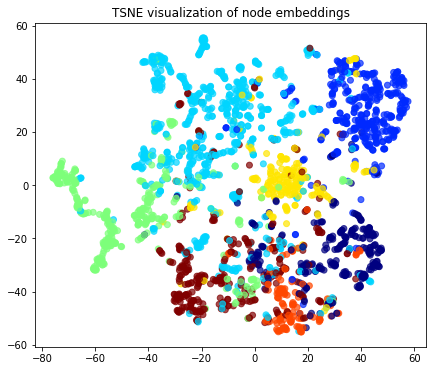

In [11]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Downstream task

The node embeddings calculated using Word2Vec can be used as feature vectors in a downstream task such as node attribute inference (e.g., inferring the subject of a paper in Cora), community detection (clustering of nodes based on the similarity of their embedding vectors), and link prediction (e.g., prediction of citation links between papers).

For a more detailed example of using Node2Vec for link prediction see [this example](../link-prediction/node2vec-link-prediction.ipynb).

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/node2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/node2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>